# Recitation Nine: Random Forests

In [1]:
# Note: today's demo is adapted from https://github.com/WillKoehrsen/Data-Analysis/tree/master/random_forest_explained

# Goal: predict the maximum temperature tomorrow for Seattle, Washington given one year of historical data?

# Data: maximum and predicted temperatures in Seattle (NOAA)

# Pandas is used for data manipulation
import pandas as pd

# Read in data as pandas dataframe and display first 5 rows
features = pd.read_csv('temps.csv')
features.head(5)

,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
0,2016,1,1,Fri,45,45,45.6,45,43,50,44,29
1,2016,1,2,Sat,44,45,45.7,44,41,50,44,61
2,2016,1,3,Sun,45,44,45.8,41,43,46,47,56
3,2016,1,4,Mon,44,41,45.9,40,44,48,46,53
4,2016,1,5,Tues,41,40,46.0,44,46,46,46,41


In [2]:
print(features.shape)

# Convert categorical variable into dummy/indicator variables.
features = pd.get_dummies(features)
print(features.shape)

(348, 12)
(348, 18)


In [3]:
# Use datetime for dealing with dates
import datetime

# Get years, months, and days
years = features['year']
months = features['month']
days = features['day']

# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

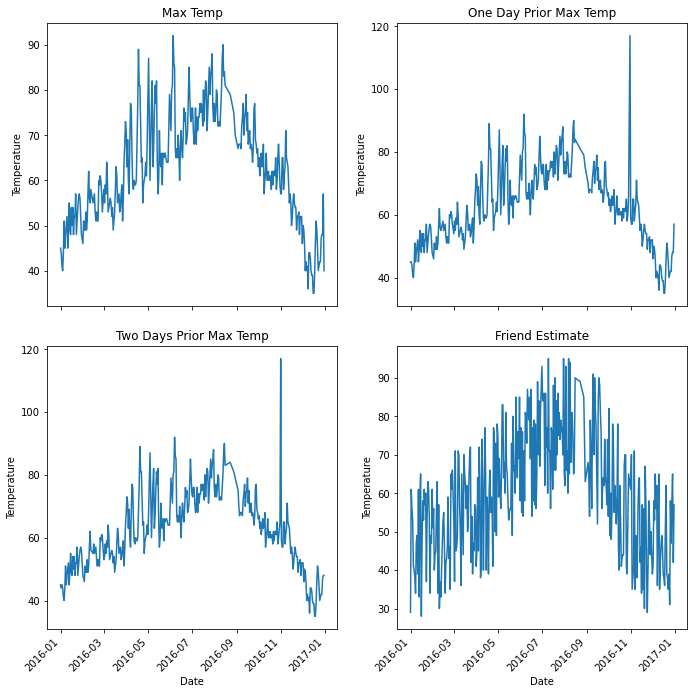

In [4]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
# plt.style.use('fivethirtyeight')

# Set up the plotting layout
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (10,10))
fig.autofmt_xdate(rotation = 45)

# Actual max temperature measurement
ax1.plot(dates, features['actual'])
ax1.set_xlabel(''); ax1.set_ylabel('Temperature'); ax1.set_title('Max Temp')

# Temperature from 1 day ago
ax2.plot(dates, features['temp_1'])
ax2.set_xlabel(''); ax2.set_ylabel('Temperature'); ax2.set_title('One Day Prior Max Temp')

# Temperature from 2 days ago
ax3.plot(dates, features['temp_2'])
ax3.set_xlabel('Date'); ax3.set_ylabel('Temperature'); ax3.set_title('Two Days Prior Max Temp')

# Friend Estimate
ax4.plot(dates, features['friend'])
ax4.set_xlabel('Date'); ax4.set_ylabel('Temperature'); ax4.set_title('Friend Estimate')

plt.tight_layout(pad=2)

In [5]:
# Use numpy to convert to arrays
import numpy as np

# Labels are the values we want to predict
labels = np.array(features['actual'])

# Remove the labels from the features
# axis 1 refers to the columns
features= features.drop('actual', axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

## Training and Testing Sets

In [6]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25,
                                                                           random_state = 42)

In [7]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (261, 17)
Training Labels Shape: (261,)
Testing Features Shape: (87, 17)
Testing Labels Shape: (87,)


## Establish Baseline

In [8]:
# The baseline predictions are the historical averages
baseline_preds = test_features[:, feature_list.index('average')]

# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - test_labels)
print('Mean absolute error: ', round(np.mean(baseline_errors), 2))

Mean absolute error:  5.06


## Training the Forest

In [19]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model 
rf = RandomForestRegressor(n_estimators= 1000, random_state=42)

# Train the model on training data
rf.fit(train_features, train_labels);

#help(RandomForestRegressor)

In [20]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 3.87 degrees.


We can create models with different hyperparameters to try and boost performance. The only way to find the best ones
are to try a few and evaluate them! 

## Tuning Random Forests

In [21]:
# Define function to evaluate performance
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    print('Mean Absolute Error: {:0.4f} degrees.'.format(np.mean(errors)))
from sklearn.model_selection import GridSearchCV

# Create the parameter grid 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                           scoring = 'neg_mean_absolute_error', cv = 3, 
                           n_jobs = -1, verbose = 2)

In [23]:
# Fit the grid search to the data
grid_search.fit(train_features, train_labels)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 389 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:   42.0s finished


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 1000]},
             scoring='neg_mean_absolute_error', verbose=2)

In [24]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 110,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 200}

In [25]:
best_grid = grid_search.best_estimator_
evaluate(best_grid, test_features, test_labels)

Mean Absolute Error: 3.7559 degrees.


In [26]:
best_grid

RandomForestRegressor(max_depth=110, max_features=3, min_samples_leaf=3,
                      min_samples_split=8, n_estimators=200)

## Variable Importance

In [28]:
# Get numerical feature importances
rf = best_grid

importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {:.3f}'.format(*pair)) for pair in feature_importances];

Variable: average              Importance: 0.190
Variable: temp_1               Importance: 0.180
Variable: forecast_acc         Importance: 0.160
Variable: forecast_under       Importance: 0.130
Variable: forecast_noaa        Importance: 0.120
Variable: temp_2               Importance: 0.110
Variable: friend               Importance: 0.050
Variable: month                Importance: 0.040
Variable: day                  Importance: 0.010
Variable: year                 Importance: 0.000
Variable: week_Fri             Importance: 0.000
Variable: week_Mon             Importance: 0.000
Variable: week_Sat             Importance: 0.000
Variable: week_Sun             Importance: 0.000
Variable: week_Thurs           Importance: 0.000
Variable: week_Tues            Importance: 0.000
Variable: week_Wed             Importance: 0.000


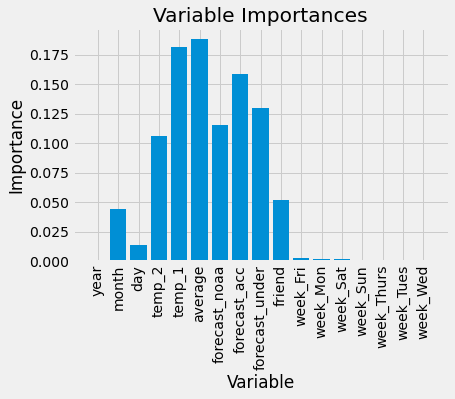

In [29]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt

%matplotlib inline

# Set the style
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances'); 